<a href="https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/Fine_tuning_LayoutLMForTokenClassification_on_FUNSD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction

In this notebook, we are going to fine-tune the LayoutLM model by Microsoft Research on the [FUNSD](https://guillaumejaume.github.io/FUNSD/) dataset, which is a collection of annotated form documents. The goal of our model is to learn the annotations of a number of labels ("question", "answer", "header" and "other") on those forms, such that it can be used to annotate unseen forms in the future.

* Original LayoutLM paper: https://huggingface.co/papers/1912.13318

* Original FUNSD paper: https://huggingface.co/papers/1905.13538


## Install libraries

Currently you have to first install the `unilm` package, and then the `transformers` package (which updates the outdated `transformers` package that is included in the `unilm` package). The reason we also install the `unilm` package is because we need its preprocessing files. I've forked it, and removed some statements which introduced some issues.

In [ ]:
! rm -r unilm
! git clone https://github.com/microsoft/unilm.git

## Getting the data

Here we download the data of the [FUNSD dataset](https://guillaumejaume.github.io/FUNSD/) from the web. This results in a directory called "data" being created, which has 2 subdirectories, one for training and one for testing. Each of those has 2 subdirectories in turn, one containing the images as png files and one containing the annotations in json format.

In [ ]:
! wget https://guillaumejaume.github.io/FUNSD/dataset.zip
! unzip dataset.zip && mv dataset data && rm -rf dataset.zip __MACOSX

Let's take a look at a training example. For this, we are going to use PIL (Python Image Library).

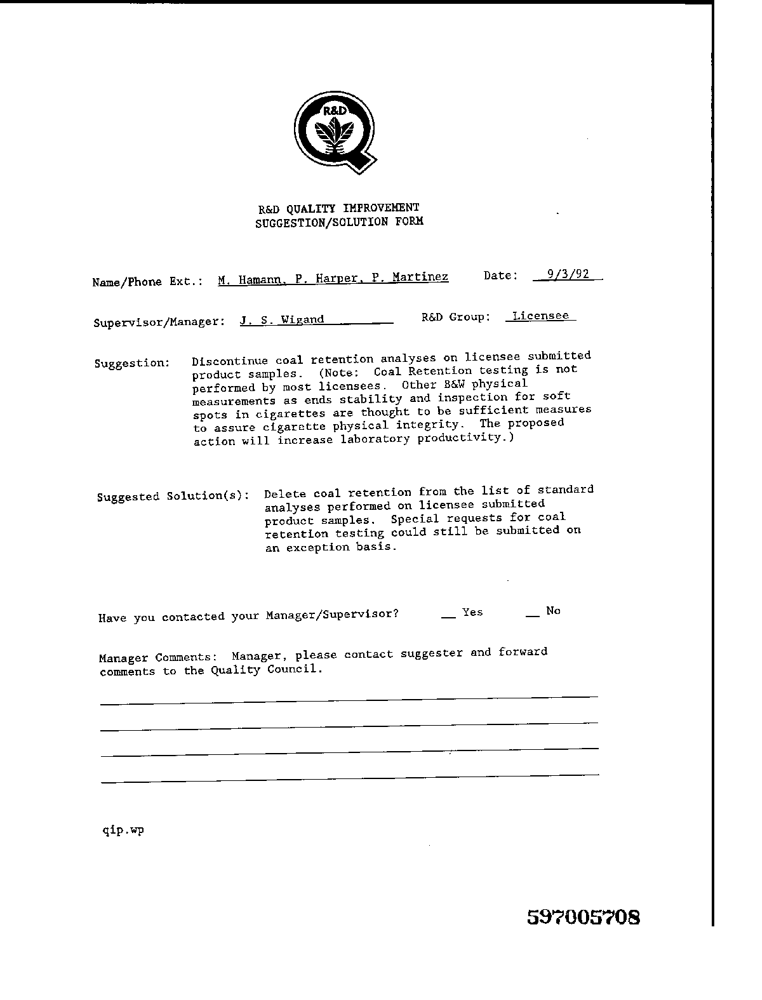

In [5]:
from PIL import Image, ImageDraw, ImageFont
import os

base_path = "./data"

image = Image.open(os.path.join(base_path, "training_data/images/0000971160.png"))
image = image.convert("RGB")
image

Now let's plot its corresponding annotations. Basically, if you type `data['form']`, you get a list of all general annotations. Each general annotation has a label, a bounding box, and one or more words, which in also have their own bounding box. The bounding boxes are in [xleft, ytop, xright, ybottom] format.
 

In [6]:
import json

with open(os.path.join(base_path, "training_data/annotations/0000971160.json")) as f:
    data = json.load(f)

for annotation in data["form"]:
    print(annotation)

{'box': [292, 91, 376, 175], 'text': 'R&D', 'label': 'other', 'words': [{'box': [292, 91, 376, 175], 'text': 'R&D'}], 'linking': [], 'id': 0}
{'box': [219, 316, 225, 327], 'text': ':', 'label': 'question', 'words': [{'box': [219, 316, 225, 327], 'text': ':'}], 'linking': [], 'id': 1}
{'box': [95, 355, 169, 370], 'text': 'Suggestion:', 'label': 'question', 'words': [{'box': [95, 355, 169, 370], 'text': 'Suggestion:'}], 'linking': [[2, 16]], 'id': 2}
{'box': [482, 268, 518, 282], 'text': 'Date:', 'label': 'question', 'words': [{'box': [482, 268, 518, 282], 'text': 'Date:'}], 'linking': [[3, 12]], 'id': 3}
{'box': [511, 309, 570, 323], 'text': 'Licensee', 'label': 'answer', 'words': [{'box': [511, 309, 570, 323], 'text': 'Licensee'}], 'linking': [[13, 4]], 'id': 4}
{'box': [211, 651, 217, 662], 'text': '', 'label': 'question', 'words': [{'box': [211, 651, 217, 662], 'text': ''}], 'linking': [], 'id': 5}
{'box': [461, 605, 483, 619], 'text': 'Yes', 'label': 'question', 'words': [{'box': [4

The PIL library has a handy ImageDraw module, which -you guessed it- allows to draw things (such as rectangles) on an image:

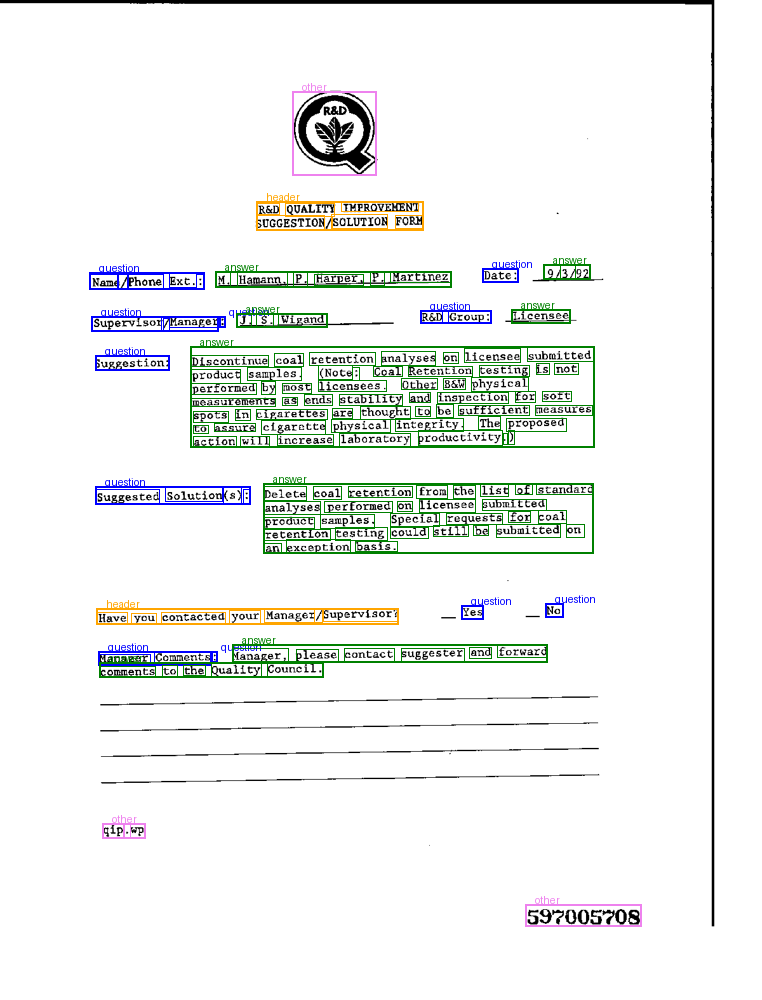

In [7]:
draw = ImageDraw.Draw(image, "RGBA")

font = ImageFont.load_default()

label2color = {"question": "blue", "answer": "green", "header": "orange", "other": "violet"}

for annotation in data["form"]:
    label = annotation["label"]
    general_box = annotation["box"]
    draw.rectangle(general_box, outline=label2color[label], width=2)
    draw.text((general_box[0] + 10, general_box[1] - 10), label, fill=label2color[label], font=font)
    words = annotation["words"]
    for word in words:
        box = word["box"]
        draw.rectangle(box, outline=label2color[label], width=1)

image

## Preprocessing the data

Next, we need to turn the document images into individual tokens and corresponding labels (BIOES format, see further). We do this both for the training and test datasets. Make sure to run this from the `/content` directory:

In [ ]:
! python unilm/layoutlm/deprecated/examples/seq_labeling/preprocess.py --data_dir data/training_data/annotations \
                                                      --data_split train \
                                                      --output_dir data \
                                                      --model_name_or_path microsoft/layoutlm-base-uncased \
                                                      --max_len 510

! python unilm/layoutlm/deprecated/examples/seq_labeling/preprocess.py --data_dir data/testing_data/annotations \
                                                      --data_split test \
                                                      --output_dir data \
                                                      --model_name_or_path microsoft/layoutlm-base-uncased \
                                                      --max_len 510

Next, we create a labels.txt file that contains the unique labels of the FUNSD dataset:

In [ ]:
! cat data/train.txt | cut -d$'\t' -f 2 | grep -v "^$"| sort | uniq > data/labels.txt

## Define a PyTorch dataset

First, we create a list containing the unique labels based on `data/labels.txt` (run this from the content directory):

In [19]:
from torch.nn import CrossEntropyLoss


def get_labels(path):
    with open(path, "r") as f:
        labels = f.read().splitlines()
    if "O" not in labels:
        labels = ["O"] + labels
    return labels


labels = get_labels("data/labels.txt")
num_labels = len(labels)
label_map = {i: label for i, label in enumerate(labels)}
# Use cross entropy ignore index as padding label id so that only real label ids contribute to the loss later
pad_token_label_id = CrossEntropyLoss().ignore_index

We can see that the dataset uses the so-called BIOES annotation scheme to annotate the tokens. This means that a given token can be either at the beginning (B), inside (I), outside (O), at the end (E) or start (S) of a given entity. Entities include ANSWER, QUESTION, HEADER and OTHER: 

In [20]:
print(labels)

['B-ANSWER', 'B-HEADER', 'B-QUESTION', 'E-ANSWER', 'E-HEADER', 'E-QUESTION', 'I-ANSWER', 'I-HEADER', 'I-QUESTION', 'O', 'S-ANSWER', 'S-HEADER', 'S-QUESTION']


Next, we can create a PyTorch dataset and corresponding dataloader (both for training and evaluation):

In [21]:
import logging
import os

import torch
from torch.utils.data import Dataset

logger = logging.getLogger(__name__)


class FunsdDataset(Dataset):
    def __init__(self, args, tokenizer, labels, pad_token_label_id, mode):
        if args.local_rank not in [-1, 0] and mode == "train":
            torch.distributed.barrier()  # Make sure only the first process in distributed training process the dataset, and the others will use the cache

        # Load data features from cache or dataset file
        cached_features_file = os.path.join(
            args.data_dir,
            "cached_{}_{}_{}".format(
                mode,
                list(filter(None, args.model_name_or_path.split("/"))).pop(),
                str(args.max_seq_length),
            ),
        )
        if os.path.exists(cached_features_file) and not args.overwrite_cache:
            logger.info("Loading features from cached file %s", cached_features_file)
            features = torch.load(cached_features_file)
        else:
            logger.info("Creating features from dataset file at %s", args.data_dir)
            examples = read_examples_from_file(args.data_dir, mode)
            features = convert_examples_to_features(
                examples,
                labels,
                args.max_seq_length,
                tokenizer,
                cls_token_at_end=bool(args.model_type in ["xlnet"]),
                # xlnet has a cls token at the end
                cls_token=tokenizer.cls_token,
                cls_token_segment_id=2 if args.model_type in ["xlnet"] else 0,
                sep_token=tokenizer.sep_token,
                sep_token_extra=bool(args.model_type in ["roberta"]),
                # roberta uses an extra separator b/w pairs of sentences, cf. github.com/pytorch/fairseq/commit/1684e166e3da03f5b600dbb7855cb98ddfcd0805
                pad_on_left=bool(args.model_type in ["xlnet"]),
                # pad on the left for xlnet
                pad_token=tokenizer.convert_tokens_to_ids([tokenizer.pad_token])[0],
                pad_token_segment_id=4 if args.model_type in ["xlnet"] else 0,
                pad_token_label_id=pad_token_label_id,
            )
            # if args.local_rank in [-1, 0]:
            # logger.info("Saving features into cached file %s", cached_features_file)
            # torch.save(features, cached_features_file)

        if args.local_rank == 0 and mode == "train":
            torch.distributed.barrier()  # Make sure only the first process in distributed training process the dataset, and the others will use the cache

        self.features = features
        # Convert to Tensors and build dataset
        self.all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
        self.all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
        self.all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)
        self.all_label_ids = torch.tensor([f.label_ids for f in features], dtype=torch.long)
        self.all_bboxes = torch.tensor([f.boxes for f in features], dtype=torch.long)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, index):
        return (
            self.all_input_ids[index],
            self.all_input_mask[index],
            self.all_segment_ids[index],
            self.all_label_ids[index],
            self.all_bboxes[index],
        )


class InputExample(object):
    """A single training/test example for token classification."""

    def __init__(self, guid, words, labels, boxes, actual_bboxes, file_name, page_size):
        """Constructs a InputExample.

        Args:
            guid: Unique id for the example.
            words: list. The words of the sequence.
            labels: (Optional) list. The labels for each word of the sequence. This should be
            specified for train and dev examples, but not for test examples.
        """
        self.guid = guid
        self.words = words
        self.labels = labels
        self.boxes = boxes
        self.actual_bboxes = actual_bboxes
        self.file_name = file_name
        self.page_size = page_size


class InputFeatures(object):
    """A single set of features of data."""

    def __init__(
        self,
        input_ids,
        input_mask,
        segment_ids,
        label_ids,
        boxes,
        actual_bboxes,
        file_name,
        page_size,
    ):
        assert (
            0 <= all(boxes) <= 1000
        ), "Error with input bbox ({}): the coordinate value is not between 0 and 1000".format(boxes)
        self.input_ids = input_ids
        self.input_mask = input_mask
        self.segment_ids = segment_ids
        self.label_ids = label_ids
        self.boxes = boxes
        self.actual_bboxes = actual_bboxes
        self.file_name = file_name
        self.page_size = page_size


def read_examples_from_file(data_dir, mode):
    file_path = os.path.join(data_dir, "{}.txt".format(mode))
    box_file_path = os.path.join(data_dir, "{}_box.txt".format(mode))
    image_file_path = os.path.join(data_dir, "{}_image.txt".format(mode))
    guid_index = 1
    examples = []
    with open(file_path, encoding="utf-8") as f, open(box_file_path, encoding="utf-8") as fb, open(
        image_file_path, encoding="utf-8"
    ) as fi:
        words = []
        boxes = []
        actual_bboxes = []
        file_name = None
        page_size = None
        labels = []
        for line, bline, iline in zip(f, fb, fi):
            if line.startswith("-DOCSTART-") or line == "" or line == "\n":
                if words:
                    examples.append(
                        InputExample(
                            guid="{}-{}".format(mode, guid_index),
                            words=words,
                            labels=labels,
                            boxes=boxes,
                            actual_bboxes=actual_bboxes,
                            file_name=file_name,
                            page_size=page_size,
                        )
                    )
                    guid_index += 1
                    words = []
                    boxes = []
                    actual_bboxes = []
                    file_name = None
                    page_size = None
                    labels = []
            else:
                splits = line.split("\t")
                bsplits = bline.split("\t")
                isplits = iline.split("\t")
                assert len(splits) == 2
                assert len(bsplits) == 2
                assert len(isplits) == 4
                assert splits[0] == bsplits[0]
                words.append(splits[0])
                if len(splits) > 1:
                    labels.append(splits[-1].replace("\n", ""))
                    box = bsplits[-1].replace("\n", "")
                    box = [int(b) for b in box.split()]
                    boxes.append(box)
                    actual_bbox = [int(b) for b in isplits[1].split()]
                    actual_bboxes.append(actual_bbox)
                    page_size = [int(i) for i in isplits[2].split()]
                    file_name = isplits[3].strip()
                else:
                    # Examples could have no label for mode = "test"
                    labels.append("O")
        if words:
            examples.append(
                InputExample(
                    guid="%s-%d".format(mode, guid_index),
                    words=words,
                    labels=labels,
                    boxes=boxes,
                    actual_bboxes=actual_bboxes,
                    file_name=file_name,
                    page_size=page_size,
                )
            )
    return examples


def convert_examples_to_features(
    examples,
    label_list,
    max_seq_length,
    tokenizer,
    cls_token_at_end=False,
    cls_token="[CLS]",
    cls_token_segment_id=1,
    sep_token="[SEP]",
    sep_token_extra=False,
    pad_on_left=False,
    pad_token=0,
    cls_token_box=[0, 0, 0, 0],
    sep_token_box=[1000, 1000, 1000, 1000],
    pad_token_box=[0, 0, 0, 0],
    pad_token_segment_id=0,
    pad_token_label_id=-1,
    sequence_a_segment_id=0,
    mask_padding_with_zero=True,
):
    """Loads a data file into a list of `InputBatch`s
    `cls_token_at_end` define the location of the CLS token:
        - False (Default, BERT/XLM pattern): [CLS] + A + [SEP] + B + [SEP]
        - True (XLNet/GPT pattern): A + [SEP] + B + [SEP] + [CLS]
    `cls_token_segment_id` define the segment id associated to the CLS token (0 for BERT, 2 for XLNet)
    """

    label_map = {label: i for i, label in enumerate(label_list)}

    features = []
    for ex_index, example in enumerate(examples):
        file_name = example.file_name
        page_size = example.page_size
        width, height = page_size
        if ex_index % 10000 == 0:
            logger.info("Writing example %d of %d", ex_index, len(examples))

        tokens = []
        token_boxes = []
        actual_bboxes = []
        label_ids = []
        for word, label, box, actual_bbox in zip(example.words, example.labels, example.boxes, example.actual_bboxes):
            word_tokens = tokenizer.tokenize(word)
            tokens.extend(word_tokens)
            token_boxes.extend([box] * len(word_tokens))
            actual_bboxes.extend([actual_bbox] * len(word_tokens))
            # Use the real label id for the first token of the word, and padding ids for the remaining tokens
            label_ids.extend([label_map[label]] + [pad_token_label_id] * (len(word_tokens) - 1))

        # Account for [CLS] and [SEP] with "- 2" and with "- 3" for RoBERTa.
        special_tokens_count = 3 if sep_token_extra else 2
        if len(tokens) > max_seq_length - special_tokens_count:
            tokens = tokens[: (max_seq_length - special_tokens_count)]
            token_boxes = token_boxes[: (max_seq_length - special_tokens_count)]
            actual_bboxes = actual_bboxes[: (max_seq_length - special_tokens_count)]
            label_ids = label_ids[: (max_seq_length - special_tokens_count)]

        # The convention in BERT is:
        # (a) For sequence pairs:
        #  tokens:   [CLS] is this jack ##son ##ville ? [SEP] no it is not . [SEP]
        #  type_ids:   0   0  0    0    0     0       0   0   1  1  1  1   1   1
        # (b) For single sequences:
        #  tokens:   [CLS] the dog is hairy . [SEP]
        #  type_ids:   0   0   0   0  0     0   0
        #
        # Where "type_ids" are used to indicate whether this is the first
        # sequence or the second sequence. The embedding vectors for `type=0` and
        # `type=1` were learned during pre-training and are added to the wordpiece
        # embedding vector (and position vector). This is not *strictly* necessary
        # since the [SEP] token unambiguously separates the sequences, but it makes
        # it easier for the model to learn the concept of sequences.
        #
        # For classification tasks, the first vector (corresponding to [CLS]) is
        # used as as the "sentence vector". Note that this only makes sense because
        # the entire model is fine-tuned.
        tokens += [sep_token]
        token_boxes += [sep_token_box]
        actual_bboxes += [[0, 0, width, height]]
        label_ids += [pad_token_label_id]
        if sep_token_extra:
            # roberta uses an extra separator b/w pairs of sentences
            tokens += [sep_token]
            token_boxes += [sep_token_box]
            actual_bboxes += [[0, 0, width, height]]
            label_ids += [pad_token_label_id]
        segment_ids = [sequence_a_segment_id] * len(tokens)

        if cls_token_at_end:
            tokens += [cls_token]
            token_boxes += [cls_token_box]
            actual_bboxes += [[0, 0, width, height]]
            label_ids += [pad_token_label_id]
            segment_ids += [cls_token_segment_id]
        else:
            tokens = [cls_token] + tokens
            token_boxes = [cls_token_box] + token_boxes
            actual_bboxes = [[0, 0, width, height]] + actual_bboxes
            label_ids = [pad_token_label_id] + label_ids
            segment_ids = [cls_token_segment_id] + segment_ids

        input_ids = tokenizer.convert_tokens_to_ids(tokens)

        # The mask has 1 for real tokens and 0 for padding tokens. Only real
        # tokens are attended to.
        input_mask = [1 if mask_padding_with_zero else 0] * len(input_ids)

        # Zero-pad up to the sequence length.
        padding_length = max_seq_length - len(input_ids)
        if pad_on_left:
            input_ids = ([pad_token] * padding_length) + input_ids
            input_mask = ([0 if mask_padding_with_zero else 1] * padding_length) + input_mask
            segment_ids = ([pad_token_segment_id] * padding_length) + segment_ids
            label_ids = ([pad_token_label_id] * padding_length) + label_ids
            token_boxes = ([pad_token_box] * padding_length) + token_boxes
        else:
            input_ids += [pad_token] * padding_length
            input_mask += [0 if mask_padding_with_zero else 1] * padding_length
            segment_ids += [pad_token_segment_id] * padding_length
            label_ids += [pad_token_label_id] * padding_length
            token_boxes += [pad_token_box] * padding_length

        assert len(input_ids) == max_seq_length
        assert len(input_mask) == max_seq_length
        assert len(segment_ids) == max_seq_length
        assert len(label_ids) == max_seq_length
        assert len(token_boxes) == max_seq_length

        if ex_index < 5:
            logger.info("*** Example ***")
            logger.info("guid: %s", example.guid)
            logger.info("tokens: %s", " ".join([str(x) for x in tokens]))
            logger.info("input_ids: %s", " ".join([str(x) for x in input_ids]))
            logger.info("input_mask: %s", " ".join([str(x) for x in input_mask]))
            logger.info("segment_ids: %s", " ".join([str(x) for x in segment_ids]))
            logger.info("label_ids: %s", " ".join([str(x) for x in label_ids]))
            logger.info("boxes: %s", " ".join([str(x) for x in token_boxes]))
            logger.info("actual_bboxes: %s", " ".join([str(x) for x in actual_bboxes]))

        features.append(
            InputFeatures(
                input_ids=input_ids,
                input_mask=input_mask,
                segment_ids=segment_ids,
                label_ids=label_ids,
                boxes=token_boxes,
                actual_bboxes=actual_bboxes,
                file_name=file_name,
                page_size=page_size,
            )
        )
    return features

In [23]:
from transformers import LayoutLMTokenizer

# from .unilm.layoutlm.data.funsd import FunsdDataset, InputFeatures
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 16
args = {
    "local_rank": -1,
    "overwrite_cache": True,
    "data_dir": "data/",
    "model_name_or_path": "microsoft/layoutlm-base-uncased",
    "max_seq_length": 512,
    "model_type": "layoutlm",
}


# class to turn the keys of a dict into attributes (thanks Stackoverflow)
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self


args = AttrDict(args)

tokenizer = LayoutLMTokenizer.from_pretrained("microsoft/layoutlm-base-uncased")

# the LayoutLM authors already defined a specific FunsdDataset, so we are going to use this here
train_dataset = FunsdDataset(args, tokenizer, labels, pad_token_label_id, mode="train")
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)

eval_dataset = FunsdDataset(args, tokenizer, labels, pad_token_label_id, mode="test")
eval_sampler = SequentialSampler(eval_dataset)
eval_dataloader = DataLoader(eval_dataset, sampler=eval_sampler, batch_size=batch_size)

In [24]:
len(train_dataloader)

10

In [25]:
len(eval_dataloader)

4

In [26]:
batch = next(iter(train_dataloader))
input_ids = batch[0][0]
tokenizer.decode(input_ids)

'[CLS] account agency ss : date 1 / 31 / 88 insert signed 91581919 4th new albany tribune advertisements. bookkeeper mar 08 reco affidavit of performance from newspaper new albany tribune harley davidson cigarettes lorillard media service state of county of indiana ) floyd ) before me a notary public, personally appeared holly inzer who being duly sworn, says that ( he ) ( she ) is of the abovementioned newspaper and that display ads for the above account were made through the aforesaid newspaper during the month of january, 1988 as follows : column inches exclusive advertising for harley davidson cigarettes we hereby certify charges shown above on dates per attached bill are true and correct as billed to the account in upper right hand corner of the affidavit and are exclusive sworn to and subscribed before me this day of march, 1988 in testimony whereof i have set my hand and seal the day and year aforesaid. my commission expires : 2 - 9 - 90 betty j. murphy ( notary public ) [SEP] [

## Define and fine-tune the model

As this is a sequence labeling task, we are going to load `LayoutLMForTokenClassification` (the base sized model) from the hub. We are going to fine-tune it on a downstream task, namely FUNSD.

In [27]:
from peft import get_peft_config, PeftModel, get_peft_model, LoraConfig, TaskType

peft_config = LoraConfig(
    task_type=TaskType.TOKEN_CLS, inference_mode=False, r=16, lora_alpha=16, lora_dropout=0.1, bias="all"
)
peft_config

LoraConfig(task_type=<TaskType.TOKEN_CLS: 'TOKEN_CLS'>, peft_type=<PeftType.LORA: 'LORA'>, auto_mapping=None, base_model_name_or_path=None, revision=None, inference_mode=False, r=16, target_modules=None, exclude_modules=None, lora_alpha=16, lora_dropout=0.1, fan_in_fan_out=False, bias='all', use_rslora=False, modules_to_save=None, init_lora_weights=True, layers_to_transform=None, layers_pattern=None, rank_pattern={}, alpha_pattern={}, megatron_config=None, megatron_core='megatron.core', trainable_token_indices=None, loftq_config={}, eva_config=None, corda_config=None, use_dora=False, use_qalora=False, qalora_group_size=16, layer_replication=None, runtime_config=LoraRuntimeConfig(ephemeral_gpu_offload=False), lora_bias=False, target_parameters=None)

In [ ]:
from transformers import LayoutLMForTokenClassification
import torch
from transformers import set_seed

seed = 100
set_seed(seed)
device = torch.accelerator.current_accelerator().type if hasattr(torch, "accelerator") else "cuda"

model = LayoutLMForTokenClassification.from_pretrained("microsoft/layoutlm-base-uncased", num_labels=num_labels)
model = get_peft_model(model, peft_config)
model.to(device)

In [ ]:
print(model.model.layoutlm.encoder.layer[0].attention.self.query.weight)
print(model.model.layoutlm.encoder.layer[0].attention.self.query.lora_A.default.weight)
print(model.model.classifier.weight)

Now we can start training:

In [ ]:
from transformers import get_linear_schedule_with_warmup
from tqdm import tqdm

num_train_epochs = 100

optimizer = torch.optim.AdamW(model.parameters(), lr=3e-3)
lr_scheduler = get_linear_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=0.06 * (len(train_dataloader) * num_train_epochs),
    num_training_steps=(len(train_dataloader) * num_train_epochs),
)


global_step = 0

t_total = len(train_dataloader) * num_train_epochs  # total number of training steps

# put the model in training mode
model.train()
for epoch in range(num_train_epochs):
    for batch in tqdm(train_dataloader, desc="Training"):
        input_ids = batch[0].to(device)
        bbox = batch[4].to(device)
        attention_mask = batch[1].to(device)
        token_type_ids = batch[2].to(device)
        labels = batch[3].to(device)

        # forward pass
        outputs = model(
            input_ids=input_ids, bbox=bbox, attention_mask=attention_mask, token_type_ids=token_type_ids, labels=labels
        )
        loss = outputs.loss

        # print loss every 100 steps
        if global_step % 10 == 0:
            print(f"Loss after {global_step} steps: {loss.item()}")

        # backward pass to get the gradients
        loss.backward()

        # print("Gradients on classification head:")
        # print(model.classifier.weight.grad[6,:].sum())

        # update
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        global_step += 1

In [35]:
import numpy as np
from seqeval.metrics import (
    classification_report,
    f1_score,
    precision_score,
    recall_score,
)

eval_loss = 0.0
nb_eval_steps = 0
preds = None
out_label_ids = None

# put model in evaluation mode
model.eval()
for batch in tqdm(eval_dataloader, desc="Evaluating"):
    with torch.no_grad():
        input_ids = batch[0].to(device)
        bbox = batch[4].to(device)
        attention_mask = batch[1].to(device)
        token_type_ids = batch[2].to(device)
        labels = batch[3].to(device)

        # forward pass
        outputs = model(
            input_ids=input_ids, bbox=bbox, attention_mask=attention_mask, token_type_ids=token_type_ids, labels=labels
        )
        # get the loss and logits
        tmp_eval_loss = outputs.loss
        logits = outputs.logits

        eval_loss += tmp_eval_loss.item()
        nb_eval_steps += 1

        # compute the predictions
        if preds is None:
            preds = logits.detach().cpu().numpy()
            out_label_ids = labels.detach().cpu().numpy()
        else:
            preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)
            out_label_ids = np.append(out_label_ids, labels.detach().cpu().numpy(), axis=0)

# compute average evaluation loss
eval_loss = eval_loss / nb_eval_steps
preds = np.argmax(preds, axis=2)

out_label_list = [[] for _ in range(out_label_ids.shape[0])]
preds_list = [[] for _ in range(out_label_ids.shape[0])]

for i in range(out_label_ids.shape[0]):
    for j in range(out_label_ids.shape[1]):
        if out_label_ids[i, j] != pad_token_label_id:
            out_label_list[i].append(label_map[out_label_ids[i][j]])
            preds_list[i].append(label_map[preds[i][j]])

results = {
    "loss": eval_loss,
    "precision": precision_score(out_label_list, preds_list),
    "recall": recall_score(out_label_list, preds_list),
    "f1": f1_score(out_label_list, preds_list),
}
print(results)

Evaluating: 100%|██████████| 4/4 [00:00<00:00, 10.90it/s]


{'loss': 1.467050313949585, 'precision': 0.7295341474445952, 'recall': 0.806903451725863, 'f1': 0.7662707838479811}


In [36]:
model.print_trainable_parameters()

trainable params: 702,733 || all params: 113,237,786 || trainable%: 0.6206


In [37]:
model.save_pretrained("peft_layoutlm")

In [40]:
!du -h ./peft_layoutlm/adapter_model.safetensors

2.8M	./peft_layoutlm/adapter_model.safetensors
